# Detecting Translated Texts Using GRU

## How to execute



*   Run all blocks to build, train, and evluate the model. It runs with default setting. \ 
*   Default setting is GRU-3 (3 linear layers) without pre-trained vector, which is the best performing model.\
*   To change the setting, block/unblock the codes as followings.
1. Use of pre-trained embedding layer : Block/unblock the codes in part named "Embedding Mode"
2. GRU-2 / GRU-3 : Block/unblock the codes in part named "GRU-2 / GRU-3"

## Model

This is GRU-based model for translated(machine-generated) Korean sentence detection.\
GRU-2 consists of 2 linear + dropout layers.\
GRU-3 consists of 3 linear + dropout layers.

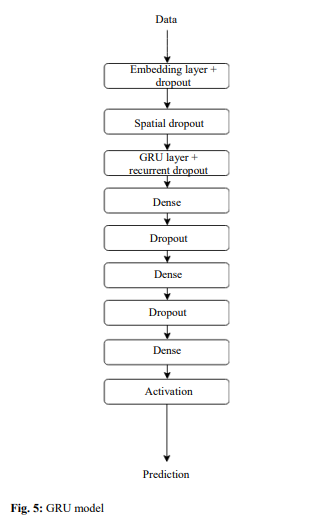


In [2]:
# Install python packages
!pip install -U torchtext==0.10.0 # torchtext https://pytorch.org/text/stable/index.html
!pip install konlpy # KoNLPy https://konlpy.org/ko/v0.6.0/
!pip install gensim # GENSIM https://radimrehurek.com/gensim/index.html#

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from google.colab import files
from torchtext.legacy import data 
from torchtext.legacy.data import TabularDataset, Iterator
from torchtext.vocab import Vectors
from sklearn.model_selection import StratifiedKFold
from konlpy.tag import Okt
from tqdm.notebook import tqdm
import gensim
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 2.6 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whee

In [3]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 75

In [4]:
# This is for debugging 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# CPU / GPU
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device is:", DEVICE)

# Load dataset
trn = pd.read_csv('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/train_.txt', sep='\t', header=0) # train set
val = pd.read_csv('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/val.txt', sep='\t', header=0) # train set
test = pd.read_csv('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/test.txt', sep='\t', header=0) # test set

tokenizer = Okt() # Konlpy's Okt tokneizer (twitter tokenizer of past)

# Build torchtext fields
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=tokenizer.pos, # Use Konlpy Okt as a tokenizer
                  #lower=True,
                  batch_first=True,
                  fix_length=44)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   is_target=True)

# 5-fold validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# for i, (trn_idx,val_idx) in enumerate(skf.split(train['text'], train['translated'])):
#     trn = train.iloc[trn_idx]
#     val = train.iloc[val_idx]

trn.to_csv('trn.csv',index = False)
val.to_csv('val.csv',index = False)
test.to_csv('test.csv',index = False)

# Build Iterators for training
train_data, validation_data, test_data = TabularDataset.splits(
    path='', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv', fields=[('label', LABEL), ('text', TEXT)], skip_header=True)

train_iter = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
val_iter = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
test_iter = Iterator(dataset = test_data, batch_size = BATCH_SIZE,shuffle = False)

print('Training set size: {}\n Validation set size : {}\n Test set size : {}'.format(len(train_data), len(validation_data),len(test_data)))
print('Train data minibatch size : {}\n Validation data minibatch size : {}\n Test data minibatch size : {}'.format(len(train_iter), len(val_iter), len(test_iter)))

Device is: cuda
Training set size: 5376
 Validation set size : 1344
 Test set size : 1680
Train data minibatch size : 84
 Validation data minibatch size : 21
 Test data minibatch size : 27


In [5]:
# Word2vec Hyperparameters
W2V_SIZE = 200
W2V_MIN_COUNT = 2

# Load pre-built word vector
wv = KeyedVectors.load('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/pos_korean_translation_restricted.vec', mmap='r') 

TEXT.build_vocab(train_data,
                 min_freq = W2V_MIN_COUNT, 
                 max_size = 20000,
                 )
word2vec_vectors = []
total = 0
new = 0

for token, idx in tqdm(TEXT.vocab.stoi.items()):
    total += 1
    token = '(\'' + '\',\''.join(token) + '\')'
    if total < 20 :
      print(token)
    if token in list(wv.vocab.keys()):
        word2vec_vectors.append(torch.FloatTensor(wv[token]))        
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
        new += 1

TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

print('Vocab size : {}'.format(len(TEXT.vocab)))
print('New token / pre-trained token : ', new, '/', total)

  0%|          | 0/12056 [00:00<?, ?it/s]

('<','u','n','k','>')
('<','p','a','d','>')
('을','Josa')
('.','Punctuation')
('이','Josa')
('에','Josa')
('의','Josa')
('"','Punctuation')
(',','Punctuation')
('를','Josa')
('은','Josa')
('했다','Verb')
('가','Josa')
('."','Punctuation')
('는','Josa')
('으로','Josa')
('에서','Josa')
('한','Josa')
('(','Punctuation')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


Vocab size : 12056
New token / pre-trained token :  2135 / 12056


In [21]:
# Blocks
class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim, softmax = False):
      super(DenseBlock, self).__init__()
      self.dense = nn.Linear(in_dim, out_dim) # dense layer
      self.act = nn.Softmax(dim=1) if softmax else nn.ReLU() # activation function

    def forward(self, x):
      x =  self.dense(x)
      out = self.act(x)
      return out

# Model
class Detector(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(Detector, self).__init__()
        print("Building Detector...")
        self.n_layers = n_layers 
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)

        ######################################################################################
        #### Embedding Modes : Unblock one of the follwing two lines and block the other. ####
        ######################################################################################
        self.embed = nn.Embedding(n_vocab, embed_dim) # without pre-trained word2vec           
        # self.embed = nn.Embedding.from_pretrained(pre_trained_emb) # with pre-trained word2vec
        ######################################################################################

        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers = self.n_layers,
                          batch_first = True)
        self.dense = DenseBlock(self.hidden_dim, self.hidden_dim)
        self.out = DenseBlock(self.hidden_dim, n_classes, True)

    def forward(self, x):
        
        # Embedding layer
        x = self.dropout(self.embed(x))      
  
        # GRU layer
        h_0 = self._init_state(batch_size=x.size(0)) # Initialize hidden vector as zero vector
        x, _ = self.gru(x, h_0)  # x : (batch_size, input length, hidden_dim)
        x = x[:,-1,:] # x : (batch_size, 1, hidden_dim), last hidden state in each batch
        x = self.dropout(x) 

        # Linear layers 
        x = self.dropout(self.dense(x))
        x = self.dropout(self.dense(x))

        ######################################################################################
        #### GRU-2 / GRU-3 : Block the follwing line to make GRU-2, unblock to make GRU-3 ####
        ######################################################################################
        # x = self.dropout(self.dense(x)) # Block: GRU-2(2 linear layers). Unblock : GRU-3(3 linear layers)
        #######################################################################################

        # Output layer
        logit = self.out(x) # ((batch_size, hidden_dim) -> (batch_size, out_dim)
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

def train(model, optimizer, train_iter):
    model.train()

    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad() 
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y) # Cross entropy
        loss.backward()
        optimizer.step()

def evaluate(model, val_iter):    
    model.eval()
    corrects, total_loss = 0, 0

    for batch in val_iter: 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y, reduction='sum') # Cross entropy
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size

    return avg_loss, avg_accuracy

In [22]:
#### pre-trained vector ####
PRE = ''
# PRE = '_pre'

#### GRU-2 / GRU-3 (number of linear layer) ####
# NUM_LINEAR = 3
NUM_LINEAR = 2 

#### Model Hyperparameter ####
n_classes = 2 
vocab_size = len(TEXT.vocab)
emb_dims = [100, 200, 300] if PRE =='' else [200]
HIDDEN_DIM = 256
DROPOUT = 0.5

N_LAYERS = NUM_LINEAR + 3

for EMB_DIM in emb_dims:

  model = Detector(N_LAYERS, HIDDEN_DIM, vocab_size, EMB_DIM, n_classes, DROPOUT).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  best_val_loss = None
  best_epoch = 0

  title = 'result%s_%d_hid%d_emb%d.txt' % (PRE, NUM_LINEAR, HIDDEN_DIM, EMB_DIM)

  with open(title,'w', encoding='utf-8') as fp:
    fp.write("Title\n")
    for e in range(1, EPOCHS+1):
        train(model, optimizer, train_iter)
        val_loss, val_accuracy = evaluate(model, val_iter)
        test_loss, test_acc = evaluate(model, test_iter)

        print("[Epoch: %d] Val. loss:%5.2f | Val. acc:%5.2f" % (e, val_loss, val_accuracy))
        print('Test loss: %5.2f | Tess acc: %5.2f' % (test_loss, test_acc))
        fp.write("%d, %5.2f, %5.2f,\n" % (e, val_loss, val_accuracy))

        # Save best model with least validation loss
        if not best_val_loss or val_loss < best_val_loss:
            if not os.path.isdir("snapshot"):
                os.makedirs("snapshot")
            torch.save(model.state_dict(), './snapshot/txtclassification.pt')
            best_epoch = e
            best_val_loss = val_loss

    model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
    test_loss, test_acc = evaluate(model, test_iter)

    print('[Best model] Epoch: %d \n Test loss: %5.2f | Test acc: %5.2f' % (best_epoch, test_loss, test_acc))
    fp.write("%d, %5.2f, %5.2f,\n" % (best_epoch, test_loss, test_acc))

  files.download(title)

Building Detector...
[Epoch: 1] Val. loss: 0.68 | Val. acc:59.67
Test loss:  0.68 | Tess acc: 60.36
[Epoch: 2] Val. loss: 0.58 | Val. acc:71.50
Test loss:  0.57 | Tess acc: 72.98
[Epoch: 3] Val. loss: 0.54 | Val. acc:77.53
Test loss:  0.53 | Tess acc: 78.21
[Epoch: 4] Val. loss: 0.55 | Val. acc:76.19
Test loss:  0.54 | Tess acc: 77.20
[Epoch: 5] Val. loss: 0.53 | Val. acc:78.72
Test loss:  0.52 | Tess acc: 78.75
[Epoch: 6] Val. loss: 0.52 | Val. acc:78.20
Test loss:  0.52 | Tess acc: 78.69
[Epoch: 7] Val. loss: 0.52 | Val. acc:78.94
Test loss:  0.52 | Tess acc: 78.87
[Epoch: 8] Val. loss: 0.51 | Val. acc:79.91
Test loss:  0.51 | Tess acc: 79.94
[Epoch: 9] Val. loss: 0.51 | Val. acc:79.17
Test loss:  0.51 | Tess acc: 79.76
[Epoch: 10] Val. loss: 0.50 | Val. acc:80.21
Test loss:  0.50 | Tess acc: 80.24
[Epoch: 11] Val. loss: 0.50 | Val. acc:80.58
Test loss:  0.50 | Tess acc: 80.48
[Epoch: 12] Val. loss: 0.49 | Val. acc:81.62
Test loss:  0.49 | Tess acc: 81.67
[Epoch: 13] Val. loss: 0.50 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Building Detector...
[Epoch: 1] Val. loss: 0.62 | Val. acc:65.10
Test loss:  0.62 | Tess acc: 66.96
[Epoch: 2] Val. loss: 0.53 | Val. acc:78.35
Test loss:  0.52 | Tess acc: 78.93
[Epoch: 3] Val. loss: 0.51 | Val. acc:78.79
Test loss:  0.52 | Tess acc: 78.63
[Epoch: 4] Val. loss: 0.61 | Val. acc:69.87
Test loss:  0.62 | Tess acc: 69.40
[Epoch: 5] Val. loss: 0.52 | Val. acc:79.24
Test loss:  0.51 | Tess acc: 80.12
[Epoch: 6] Val. loss: 0.51 | Val. acc:79.54
Test loss:  0.51 | Tess acc: 79.64
[Epoch: 7] Val. loss: 0.51 | Val. acc:79.61
Test loss:  0.50 | Tess acc: 81.31
[Epoch: 8] Val. loss: 0.51 | Val. acc:80.13
Test loss:  0.50 | Tess acc: 80.77
[Epoch: 9] Val. loss: 0.51 | Val. acc:79.02
Test loss:  0.50 | Tess acc: 80.89
[Epoch: 10] Val. loss: 0.50 | Val. acc:80.95
Test loss:  0.50 | Tess acc: 81.31
[Epoch: 11] Val. loss: 0.49 | Val. acc:81.47
Test loss:  0.48 | Tess acc: 82.68
[Epoch: 12] Val. loss: 0.49 | Val. acc:82.37
Test loss:  0.48 | Tess acc: 82.74
[Epoch: 13] Val. loss: 0.49 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Building Detector...
[Epoch: 1] Val. loss: 0.61 | Val. acc:68.15
Test loss:  0.60 | Tess acc: 69.05
[Epoch: 2] Val. loss: 0.55 | Val. acc:74.93
Test loss:  0.55 | Tess acc: 73.99
[Epoch: 3] Val. loss: 0.53 | Val. acc:77.53
Test loss:  0.54 | Tess acc: 76.37
[Epoch: 4] Val. loss: 0.53 | Val. acc:77.98
Test loss:  0.54 | Tess acc: 77.26
[Epoch: 5] Val. loss: 0.51 | Val. acc:79.09
Test loss:  0.52 | Tess acc: 79.05
[Epoch: 6] Val. loss: 0.49 | Val. acc:81.99
Test loss:  0.49 | Tess acc: 82.14
[Epoch: 7] Val. loss: 0.49 | Val. acc:82.59
Test loss:  0.48 | Tess acc: 82.80
[Epoch: 8] Val. loss: 0.49 | Val. acc:82.51
Test loss:  0.48 | Tess acc: 82.80
[Epoch: 9] Val. loss: 0.49 | Val. acc:81.62
Test loss:  0.48 | Tess acc: 82.32
[Epoch: 10] Val. loss: 0.48 | Val. acc:83.04
Test loss:  0.47 | Tess acc: 83.33
[Epoch: 11] Val. loss: 0.47 | Val. acc:83.33
Test loss:  0.48 | Tess acc: 83.15
[Epoch: 12] Val. loss: 0.48 | Val. acc:82.81
Test loss:  0.48 | Tess acc: 82.86
[Epoch: 13] Val. loss: 0.48 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#References

Dataset 
1. National Information Society Agency, AI Hub \
https://aihub.or.kr/aidata/87

Tokenizer 

2. KoNLPy \
https://konlpy.org/ko/v0.6.0/api/konlpy.tag/

Word2vec API

3. Radim Řehůřek, GENSIM API Reference - models.word2vec \
https://radimrehurek.com/gensim/models/word2vec.html

Model Design

4. Basyar, Iqbal & Adiwijaya, Kang & Murdiansyah, Danang. (2020). Email Spam Classification Using Gated Recurrent Unit and Long Short-Term Memory. Journal of Computer Science. 16. 559-567. 10.3844/jcssp.2020.559.567. \
https://thescipub.com/pdf/jcssp.2020.559.567.pdf 


Training and Evaluation
5. https://ariz1623.tistory.com/303 
6. https://github.com/yellowjs0304/3-min-pytorch_study/blob/master/07-%EC%88%9C%EC%B0%A8%EC%A0%81%EC%9D%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%B2%98%EB%A6%AC%ED%95%98%EB%8A%94_RNN/text_classification.ipynb


